# Hackathon #3

Written by Eleanor Quint

Topics: 
- Saving and loading TensorFlow models
- Running TensorFlow-based Python programs on Crane
- Overfitting, regularization, and early stopping

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import os  # to work with file paths

import tensorflow as tf         # to specify and run computation graphs
import numpy as np              # for numerical operations taking place outside of the TF graph
import matplotlib.pyplot as plt # to draw plots

mnist_dir = '/work/cse496dl/shared/hackathon/03/mnist/'

In [2]:
# extract our dataset, MNIST
train_images = np.load(mnist_dir + 'mnist_train_images.npy')
train_labels = np.load(mnist_dir + 'mnist_train_labels.npy')
test_images = np.load(mnist_dir + 'mnist_test_images.npy')
test_labels = np.load(mnist_dir + 'mnist_test_labels.npy')

In [3]:
# Clear the graph
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 784], name='data_placeholder')
# use a single name scope for the model
with tf.name_scope('linear_model') as scope:
    hidden = tf.layers.dense(x, 200, activation=tf.nn.relu, name='hidden_layer')
    output = tf.layers.dense(hidden, 10, name='output_layer')
    
    # Below is "identity trick"
    # tf.identity seems useless, but gives name to output so we can easily find it
    tf.identity(output, name='model_output')

# This is an easy way to track how much training the model has been through
# Acts as counter that updates once every time we track errors back
global_step_tensor = tf.get_variable('global_step', trainable=False, shape=[], initializer=tf.zeros_initializer)
# Declares tensorflow function for saving the model
saver = tf.train.Saver()

W0916 16:14:16.256666 47719223038080 deprecation.py:323] From <ipython-input-3-f02708e243a6>:7: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0916 16:14:16.269116 47719223038080 deprecation.py:506] From /util/opt/anaconda/deployed-conda-envs/packages/tensorflow/envs/tensorflow-1.14.0-py36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


All the preceding code is copied (with small modifications) from hackathon 2. We'll use it to illustrate saving and loading. Some notable modifications are the declaration of the 'global_step_tensor', the addition of the 'model_output' identity operation (which adds to the graph, even though we don't save the handle), and the addition of 'saver'.

### Saving and Loading TensorFlow Models

To save a model with initialized variables, we use the [save method](https://www.tensorflow.org/api_docs/python/tf/train/Saver#save) of an instance of [tf.train.Saver](https://www.tensorflow.org/api_docs/python/tf/train/Saver). Notice that this returns the checkpoint path prefix which may be passed directly to `Saver`'s load functions.

[[-0.69763786  0.05265693 -0.10597296 -0.04521304 -0.19031602  0.12239566
  -0.1009571  -0.28437117 -0.44811592  0.52677745]]


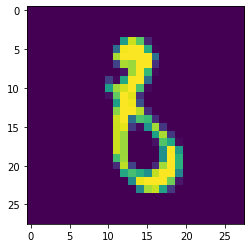

In [4]:
save_directory = './hackathon3_logs'
with tf.Session() as session:
    # Session keeps track of value of variables we are training
    session.run(tf.global_variables_initializer())
    
    # Run model forward once to get example
    # We use np.expand_dims as train_images is (50000,784) and train_images[42] is 784
    # As we are passing only one example, expand_dims turns dimension of train_images[42] to (1,784)
    img, class_vec = session.run([x, output], {x: np.expand_dims(train_images[42], axis=0)})
    print(class_vec) # Untrained output data
    imgplot = plt.imshow(img.reshape((28,28)))
    
    # the next lines save the graph and variables in save_directory 
    # as "mnist_inference.ckpt.meta" and "mnist_inference.ckpt"
    # Passing in global_step_tensor also keeps track of the counter therefore
    path_prefix = saver.save(session, os.path.join(save_directory, "mnist_classification"), global_step=global_step_tensor)
    
    

Now, we'll clear the graph and try to run a datum through the model.

In [5]:
# Clear the graph
tf.reset_default_graph()
# Declare new session
session = tf.Session()
# Grab graph for this session
graph = session.graph

# the following line fails because the placeholder tensor isn't in the graph anymore (as we reset)
# session.run(output, {x: np.expand_dims(train_images[42], axis=0)})

print(path_prefix)

./hackathon3_logs/mnist_classification-0


If the last line is uncommented, we get what is essentially an "operation not found" error. Now let's load the graph structure we saved before with [tf.train.import_meta_graph](https://www.tensorflow.org/api_docs/python/tf/train/import_meta_graph) and then use [Saver.restore](https://www.tensorflow.org/api_docs/python/tf/train/Saver#restore) to load and initialize the variable values. We can get handles to the in-graph `Tensor`s with [Graph.get_tensor_by_name](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name) and passing the name of the tensor (which is differentiated from the name of the operation by the ":0", which denotes the 0th tensor output of the op). We can then run the operations as normal.

W0916 16:14:18.118891 47719223038080 deprecation.py:323] From /util/opt/anaconda/deployed-conda-envs/packages/tensorflow/envs/tensorflow-1.14.0-py36/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


[<tf.Operation 'data_placeholder' type=Placeholder>, <tf.Operation 'hidden_layer/kernel/Initializer/random_uniform/shape' type=Const>, <tf.Operation 'hidden_layer/kernel/Initializer/random_uniform/min' type=Const>, <tf.Operation 'hidden_layer/kernel/Initializer/random_uniform/max' type=Const>, <tf.Operation 'hidden_layer/kernel/Initializer/random_uniform/RandomUniform' type=RandomUniform>, <tf.Operation 'hidden_layer/kernel/Initializer/random_uniform/sub' type=Sub>, <tf.Operation 'hidden_layer/kernel/Initializer/random_uniform/mul' type=Mul>, <tf.Operation 'hidden_layer/kernel/Initializer/random_uniform' type=Add>, <tf.Operation 'hidden_layer/kernel' type=VariableV2>, <tf.Operation 'hidden_layer/kernel/Assign' type=Assign>, <tf.Operation 'hidden_layer/kernel/read' type=Identity>, <tf.Operation 'hidden_layer/bias/Initializer/zeros' type=Const>, <tf.Operation 'hidden_layer/bias' type=VariableV2>, <tf.Operation 'hidden_layer/bias/Assign' type=Assign>, <tf.Operation 'hidden_layer/bias/read

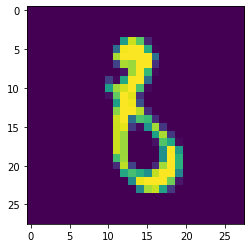

In [6]:
# loading the meta graph re-creates the graph structure in the current session, and restore initializes saved variables
saver = tf.train.import_meta_graph(path_prefix + '.meta')
# Directory where data file and index file are in is path_prefix
saver.restore(session, path_prefix)

# get handles to graph Tensors, noticing the use of name scope in retrieving model_output
x = graph.get_tensor_by_name('data_placeholder:0')

# Uses created name for output we created to grab that tensor
output = graph.get_tensor_by_name('linear_model/model_output:0')

# Prints out all operations we declared in the graph (just for information purposes)
print(graph.get_operations())

# Now rerun, exactly the same as before
img, class_vec = session.run([x, output], {x: np.expand_dims(train_images[42], axis=0)})

# We see, as expected we get the same output we did before
print(class_vec)
imgplot = plt.imshow(img.reshape((28,28)))

### Running TensorFlow-based Python programs on Crane

Because these IPython notebooks are run on the Crane login node, we should not attempt to run more than a trivially sized program. This means that we are not allowed to run more than a few training steps of a small model. Larger jobs, like fully optimizing a model, must be submitted to Slurm, the job scheduling manager for the Crane node.

We're now going to open a terminal from Jupyter to run the following commands:
"

```
cd $WORK
cp /work/cse496dl/shared/hackathon/03/run_py_496dl.sh $WORK
cp /work/cse496dl/shared/hackathon/03/basic.py $WORK
```

I've distributed a file called, "run_py_496dl.sh". It is most of what is needed to submit a Python program with TensorFlow installed and running on GPU. It expects a python file with a main function, and submits the job using `sbatch`:

`sbatch ./run_py_496dl.sh basic.py`

The way I have it written, it also passes through all arguments that follow the `.py`. Let's submit a job and then go over the details of the submit script. You can check on the status of your pending and running jobs with `squeue -u <USERNAME>`, substituting your Crane username, and you can cancel jobs with `scancel <JOBID>`, substituting the job id displayed by `squeue`. For more details, please visit the [HCC docs](https://hcc-docs.unl.edu/).

In [ ]:
# In piazza she gave us standard run_py_479.sh script

# Submitting to cse479_preempt partition allows us to submit unlimited requests, but they may be killed any
# time someone submits a job on cse479 and there are no available resources

# Submitting to cse479 is only allowed for one submission at a time, but will not be killed and has resource
# priority

# To check status run saact and it gives status of all running tasks, and canceled ones

# Using squeue -u equint shows ques and running tasks (for user named equint)
# Using squeue -p cse479 shows ques and running tasks (cse479 partition)

# To kill a job copy job ID from queue
# Use scancel 2238356 (assuming that number was the job ID)

### Overfitting, regularization, and early stopping

If we have enough parameters in our model, and little enough data, after a long period of training we begin to experience overfitting. Empirically, this is when the loss value of the data visible to the model in training drops significantly below the loss value of the data set aside for testing. It implies that the model is looking for patterns specific to the training data that won't generalize to future, unseen data. This is a problem.

Solutions? Here are some first steps to think about:

1. Get more data
2. Reduce the number of parameters in the model
3. Regularize the weight/bias parameters of the model
4. Regularize using dropout
5. Early Stopping

Let's re-specify the network with regularization from [dropout](https://www.tensorflow.org/api_docs/python/tf/layers/dropout). Other common regularizers can be found in [tf.contrib.layers](https://www.tensorflow.org/api_docs/python/tf/contrib/layers) as well.

In [7]:
tf.reset_default_graph()
# Dropout helps the neurons to not depend on each other as much

KEEP_PROB = 0.7
x = tf.placeholder(tf.float32, [None, 784], name='input_placeholder')
with tf.name_scope('linear_model') as scope:
    
    # as strange as it sounds, using dropout on the input sometimes helps
    dropped_input = tf.layers.dropout(x, KEEP_PROB)
    hidden = tf.layers.dense(dropped_input,
                             400,
                             activation=tf.nn.relu,
                             name='hidden_layer')
    
    # After hidden layer drop 30% of output before output
    dropped_hidden = tf.layers.dropout(hidden, KEEP_PROB)
    output = tf.layers.dense(dropped_hidden,
                             10,
                             name='output_layer')

W0916 16:14:18.699757 47719223038080 deprecation.py:323] From <ipython-input-7-f51f937b1f18>:7: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


Or, alternatively, a network using [tf.contrib.layers.l2_regularizer](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/l2_regularizer).

In [8]:
tf.reset_default_graph()
# Puts penalty on growth of the weights

x = tf.placeholder(tf.float32, [None, 784], name='input_placeholder')
with tf.name_scope('linear_model') as scope:
    hidden = tf.layers.dense(x,
                             400,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),
                             bias_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),
                             activation=tf.nn.relu,
                             name='hidden_layer')
    output = tf.layers.dense(hidden,
                             10,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),
                             bias_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),
                             name='output_layer')

W0916 16:14:22.280245 47719223038080 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



When using any amount of numerical regularization, it is important to add the values to the final loss function that is used in `minimize`, otherwise the regularizers do nothing. Built-in regularizers are automatically added to a list that can be retrieved with [tf.get_collection](https://www.tensorflow.org/api_docs/python/tf/get_collection) which takes a [GraphKey](https://www.tensorflow.org/api_docs/python/tf/GraphKeys) and returns a list of tensors.

In [9]:
# define classification loss WITH regularization loss
# In our case, it's L2, but could also commonly be L0, L1, or Linf
y = tf.placeholder(tf.float32, [None, 10], name='label')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=output)

# Running this line collects all regularization losses from kernel regularizers
regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
print(regularization_losses)
# this is the weight of the regularization part of the final loss
REG_COEFF = 0.001

# this value is what we'll pass to `minimize`
# This adds the regularization losses to the standard loss function
if regularization_losses:
    total_loss = cross_entropy + REG_COEFF * sum(regularization_losses)

[<tf.Tensor 'linear_model/hidden_layer/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'linear_model/hidden_layer/bias/Regularizer/l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'linear_model/output_layer/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'linear_model/output_layer/bias/Regularizer/l2_regularizer:0' shape=() dtype=float32>]


Finally, the most important tool to combat overfitting is early stopping. This is the practice of saving copies of the parameters periodically and, after you've recognized that over-fitting is occurring (i.e., when the loss on the validation/test data doesn't decrease for a number of epochs), stop training and report the best saved copy of the parameters rather than the overfit version.

Whether deciding which set of parameters to use from training or trying to decide which form of regularization will work best by trying different kinds, you can get a better idea of how your regularization decisions will affect true generalization by further splitting the training data into training and validation sets. The validation data is left unused in adjusting model parameters, but is still used in training to make regularization decisions, and this leaves the test data to be the true measure of generalization.

You might use a function like the following for the task of splitting your data into two numpy arrays.

In [10]:
# Early stopping example not given

# The below code may be useful in HW
# Used for splitting data into different proportions
def split_data(data, proportion):
    """
    Split a numpy array into two parts of `proportion` and `1 - proportion`
    
    Args:
        - data: numpy array, to be split along the first axis
        - proportion: a float less than 1
    """
    size = data.shape[0]
    split_idx = int(proportion * size)
    np.shuffle(data)
    return data[:split_idx], data[split_idx:]

## Hackathon 3 Exercise 1

Modify the `basic.py` file to add L2 regularization, split the training data to get a validation set, calculate loss on the validation (similar to test), and add early stopping. Train the model on Crane, submitting the job with `sbatch` and report the train, validation, and test loss values of the best set of parameters, along with the training epoch number they were saved from. (This is very similar to what you need to do for the first homework)

In [11]:
# Modify the basic.py file given on Piazza, not just this notebook
# However, just submit this notebook, with the four values requested below

### 1) MODIFY THE CODE, 2) TRAIN ON CRANE, 3) FILL THESE IN 4) SUBMIT THIS .IPYNB
# EPOCH: 14
# TRAIN LOSS: 0.045720665766434236
# VALIDATION LOSS: 0.07949269613759084
# TEST LOSS: 0.10437090009450913